In [1]:
%matplotlib inline
from osgeo import gdal
import numpy as np
import os
import scipy.ndimage
import scipy.stats
import matplotlib.pyplot as plt
import time
import skimage.measure
import skimage.transform
import sklearn.preprocessing
import pandas as pd

In [2]:
def make_raster(in_ds, fn, data, data_type, nodata=None): 
    """Create a one-band GeoTIFF.
    in_ds     - datasource to copy projection and geotransform from
    fn        - path to the file to create
    data      - NumPy array containing data to write
    data_type - output data type
    nodata    - optional NoData value
    """
    driver = gdal.GetDriverByName('GTiff')
    out_ds = driver.Create(fn, in_ds.RasterXSize, in_ds.RasterYSize, 1, data_type)
    out_ds.SetProjection(in_ds.GetProjection()) 
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    out_band = out_ds.GetRasterBand(1)
    if nodata is not None:
        out_band.SetNoDataValue(nodata)
        out_band.WriteArray(data)
        out_band.FlushCache()
        out_band.ComputeStatistics(False)
    return out_ds

In [3]:
# Write a function that calculates slope using a 3x3 window.
# This will be passed to the SciPy filter function below.
def slope(data, cell_width, cell_height):
    """Calculates slope using a 3x3 window.

    data        - 1D array containing the 9 pixel values, starting
                  in the upper left and going left to right and down
    cell_width  - pixel width in the same units as the data
    cell_height - pixel height in the same units as the data
    """
    rise = ((data[6] + (2 * data[7]) + data[8]) - (data[0] + (2 * data[1]) + data[2])) / (8 * cell_height)
    run =  ((data[2] + (2 * data[5]) + data[8]) - (data[0] + (2 * data[3]) + data[6])) / (8 * cell_width)
    dist = np.sqrt(np.square(rise) + np.square(run))
    return np.arctan(dist) * 180 / np.pi

In [4]:
# Write a function that calculates 3D area of DEM using a 3x3 window.
# This will be passed to the SciPy filter function below.
def area3D(data, cell_width, cell_height):
    """Calculates area per cell using a 3x3 window and a triangulated regular network.

    data        - 1D array containing the 9 pixel values, starting
                  in the upper left and going left to right and down
    cell_width  - pixel width in the same units as the data
    cell_height - pixel height in the same units as the data
    """
    
    xyz1 = np.array([0*cell_height,1*cell_width,data[1]])
    xyz2 = np.array([0*cell_height,2*cell_width,data[2]])
    xyz3 = np.array([1*cell_height,0*cell_width,data[3]])
    xyz4 = np.array([1*cell_height,1*cell_width,data[4]])
    xyz5 = np.array([1*cell_height,2*cell_width,data[5]])
    xyz6 = np.array([2*cell_height,0*cell_width,data[6]])
    xyz7 = np.array([2*cell_height,1*cell_width,data[7]])
    
    base12 = np.linalg.norm(xyz1 - xyz2)
    base34 = np.linalg.norm(xyz3 - xyz4)
    base45 = np.linalg.norm(xyz4 - xyz5)
    base67 = np.linalg.norm(xyz6 - xyz7)
    
    height14 = np.linalg.norm(xyz1 - xyz4)
    height25 = np.linalg.norm(xyz2 - xyz5)
    height36 = np.linalg.norm(xyz3 - xyz6)
    height47 = np.linalg.norm(xyz4 - xyz7)
    
    t124 = base12*height14/2
    t134 = base34*height14/2
    t245 = base45*height25/2
    t346 = base34*height36/2
    t457 = base45*height47/2
    t467 = base67*height47/2
    
    area = 0.25*(t124+t245+t346+t467)+0.5*(t134+t457)
    
    return area

In [5]:
#in_fn = '/Users/opizarro/data/FK20180119/bathy/hawaii_bty_5m_Au_au_0-400m.tif' # low res version - not 5m
in_fn = '/Users/opizarro/data/FK20180119/bathy/au_au_clipped_UTM_4N.tif'

In [34]:
# test section of input data
in_ds = gdal.Open(in_fn)

#off_ulx = 3300
#off_uly = 2000

off_ulx = 3600 #2800
off_uly = 1000
columns = 1000
rows = 800
in_data = in_ds.GetRasterBand(1).ReadAsArray(off_ulx, off_uly, columns, rows)

#testing result invariance to rotation / mirrors
#in_data = np.flipud(in_data)
#in_data = np.rot90(np.rot90(in_data))

np.save('/Users/opizarro/data/FK20180119/bathy_patch.npy',in_data)

#cell_width = 5
cell_width = np.abs(in_ds.GetGeoTransform()[1])
#cell_height = 5 
cell_height = np.abs(in_ds.GetGeoTransform()[5])
print("cell height ",cell_height)
print("cell width ",cell_width)
print("input data shape ",in_data.shape)

('cell height ', 4.9997952662983325)
('cell width ', 4.9996294227748201)
('input data shape ', (800, 1000))


In [35]:
# wrapper functon to allow for different window sizes


        
def fit_plane_local_a(data, cell_width, cell_height,Pinv):
    
    theta = np.dot(Pinv,data)
    a = theta[0]
    return a

def fit_plane_local_b(data, cell_width, cell_height,Pinv):
    
    theta = np.dot(Pinv,data)
    b = theta[1]
    return b

def fit_plane_window(in_data, win_size, cell_width, cell_height ):
    
    dim = win_size
    npoints = dim**2
    M = np.ones((npoints,3)) 
    k = 0
    for i in range(dim):
        for j in range(dim):
            M[k,:] = [j*cell_width, i*cell_height, 1]
            k+=1

    Pinv = np.linalg.pinv(M)        

    a = scipy.ndimage.filters.generic_filter(in_data, fit_plane_local_a, size=win_size, mode='nearest', extra_arguments=(
        cell_width, cell_height, Pinv))
    
    b = scipy.ndimage.filters.generic_filter(in_data, fit_plane_local_b, size=win_size, mode='nearest', extra_arguments=(
        cell_width, cell_height, Pinv))
    
    # plane equation is ax + by +c = z
    # or a*(j*cw) + b*(i*ch) + c = z
    slope = np.arctan(np.sqrt(np.square(a)+np.square(b)))*180/np.pi
    aspect = np.arctan2(b,a)*180/np.pi
    # area per horizontal unit area
    areaphua = np.sqrt(np.square(a)+np.square(b)+np.ones(a.shape))
    print(slope.shape)
    print(aspect.shape)
        
    return (slope, aspect, areaphua, a, b)


('shape of area3 ', (800, 1000))
('ellapsed time ', 37.891804933547974)


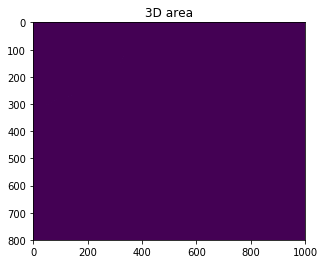

In [36]:
# calculate 3D area per cell
tic = time.time()
area3 = scipy.ndimage.filters.generic_filter(in_data, area3D, size=3, mode='nearest', extra_arguments=(
        cell_width, cell_height))
toc = time.time()
print("shape of area3 ",area3.shape)
print("ellapsed time ",toc-tic)
plt.figure(1)
plt.imshow(area3)
plt.draw()
plt.title("3D area")
plt.show(block=False)


('window size ', 3)
(800, 1000)
(800, 1000)
('shape of slope ', (800, 1000))
('ellapsed time ', 1.7918219566345215)
('window size ', 7)
(800, 1000)
(800, 1000)
('shape of slope ', (800, 1000))
('ellapsed time ', 1.9910461902618408)
('window size ', 11)
(800, 1000)
(800, 1000)
('shape of slope ', (800, 1000))
('ellapsed time ', 2.204500913619995)
('window size ', 15)
(800, 1000)
(800, 1000)
('shape of slope ', (800, 1000))
('ellapsed time ', 2.83941912651062)


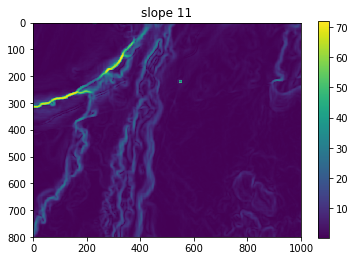

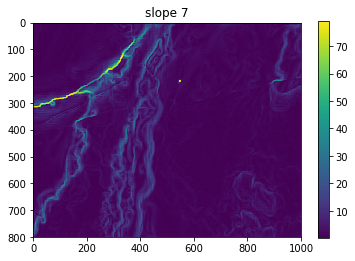

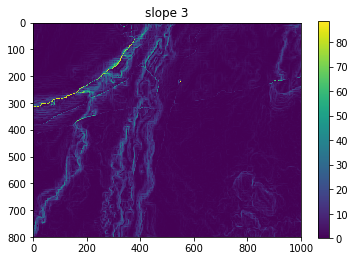

In [37]:
scales = []
feat = []
win_sizes = [3,7,11,15]
num_scales = len(win_sizes)
for win_size in win_sizes:
    print("window size ", win_size)
    tic = time.time()
    slope, aspect, areaphua, a, b = fit_plane_window(in_data, win_size, cell_width, cell_height)
   
    area3Dwin = scipy.ndimage.filters.uniform_filter(area3,win_size)
    rugosity = np.divide(area3Dwin,areaphua*cell_width*cell_height)
    
    toc = time.time()
    
    scales.append((win_size,slope, aspect, rugosity, area3Dwin, areaphua, a, b))
    
    feat.append(np.log(slope))
    feat.append(aspect)
    feat.append(np.log(rugosity))
    
    avdepth = scipy.ndimage.filters.uniform_filter(in_data,win_size)
    feat.append(avdepth)
    feat.append(in_data-avdepth) # local variation
    
    #feat.append(np.stack((slope, aspect, rugosity), axis=-1))
    #print("feat shape " ,np.stack((slope, aspect, rugosity), axis=-1).shape)
    print("shape of slope ", slope.shape)
    print("ellapsed time ", toc-tic)
    plt.figure(win_size*5)
    plt.imshow(slope)
    plt.title('slope %s'%(win_size))
    plt.colorbar()
    
#    plt.figure(win_size*5+1)
#    plt.imshow(aspect, cmap="hsv")
#    plt.title('aspect %s'%(win_size))
    
#    plt.figure(win_size*5+2)
#    plt.imshow(rugosity)
#    plt.title('rugosity %s'%(win_size))
    
#    plt.figure(win_size*5+3)
#    plt.imshow(area3Dwin)
#    plt.title('area3Dwin %s'%(win_size))
    
#    plt.figure(win_size*5+4)
#    plt.imshow(areaphua)
#    plt.title('areaphua %s'%(win_size))
    
    
plt.show(block=False)

# add depth data
feat.append(in_data)
# stack list in 3 dimensional array (last dimension is the number of derived features)
featstack = np.stack(feat,axis=-1)

('feature stack shape ', (800, 1000, 21))


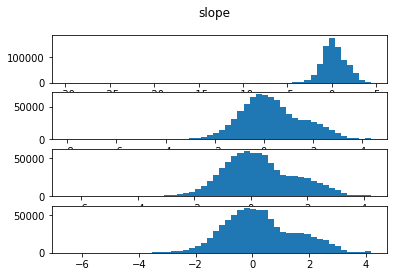

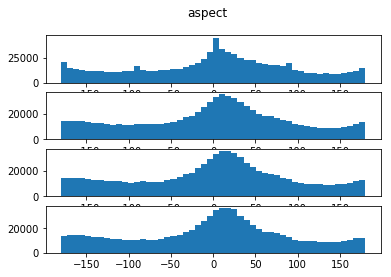

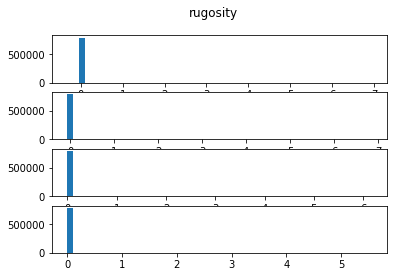

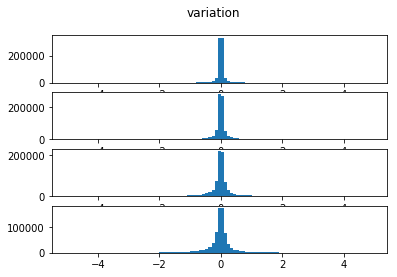

In [38]:
#print("in_data shape ",in_data.shape)
#feat= []
#feat.append(in_data)

featstack_orig = featstack # save a copy
print("feature stack shape ",featstack.shape)

plt.figure(5)
nplots = featstack.shape[2]
f, faxarr = plt.subplots(4,1)
g, gaxarr = plt.subplots(4,1)
h, haxarr = plt.subplots(4,1)
j, jaxarr = plt.subplots(4,1)
m, maxarr = plt.subplots(4,1)

f.suptitle("slope")
g.suptitle("aspect")
h.suptitle("rugosity")
j.suptitle("avdepth")
m.suptitle("variation")

for k in range(4):
    faxarr[k].hist(featstack[:,:,5*k].flatten(),bins=50)
    gaxarr[k].hist(featstack[:,:,5*k+1].flatten(),bins=50)
    #haxarr[k].hist(featstack[:,:,5*k+2].flatten(),bins=np.arange(0.99,1.15,0.005))
    haxarr[k].hist(featstack[:,:,5*k+2].flatten(),bins=50)
    jaxarr[k].hist(featstack[:,:,5*k+3].flatten(),bins=50)
    maxarr[k].hist(featstack[:,:,5*k+4].flatten(),bins=np.arange(-5,5,0.1))
plt.show(block=False)




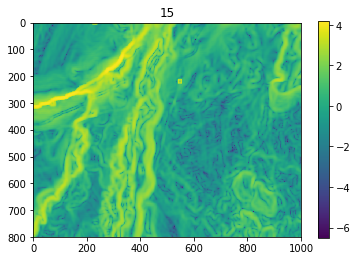

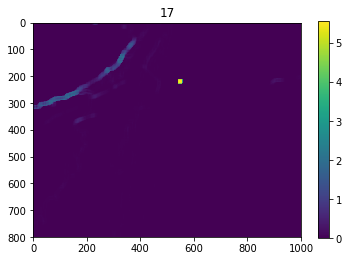

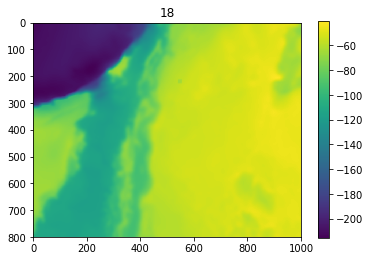

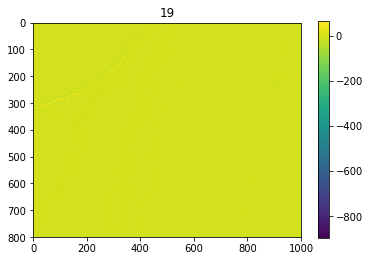

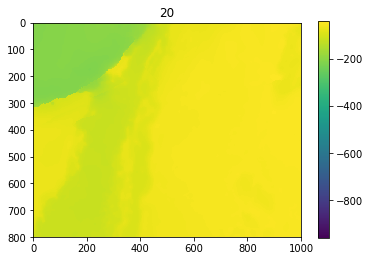

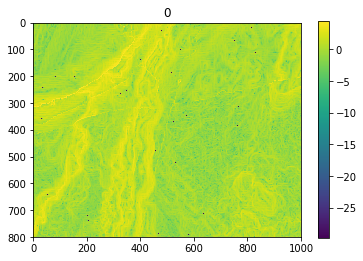

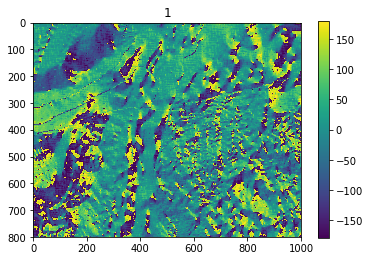

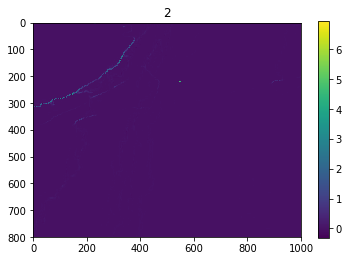

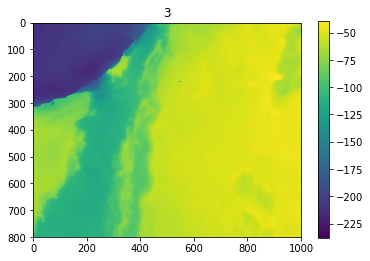

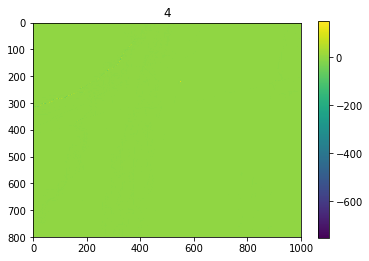

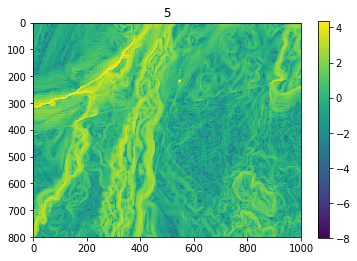

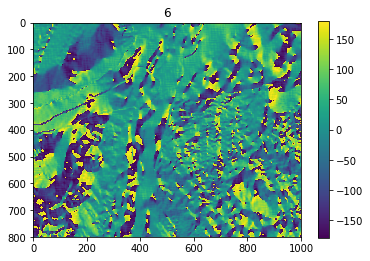

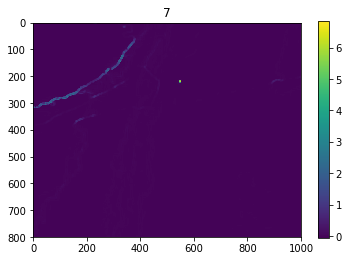

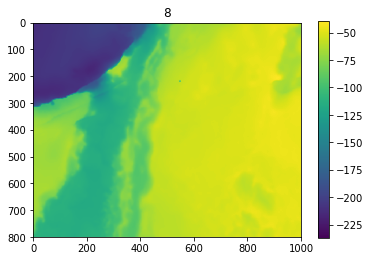

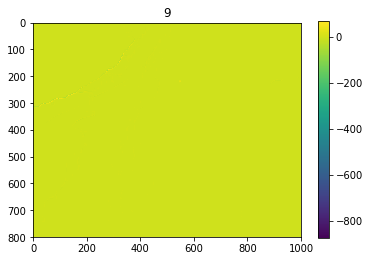

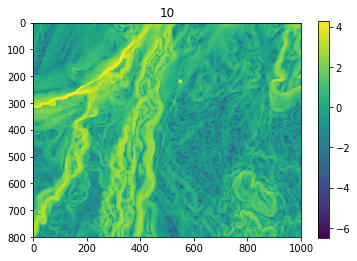

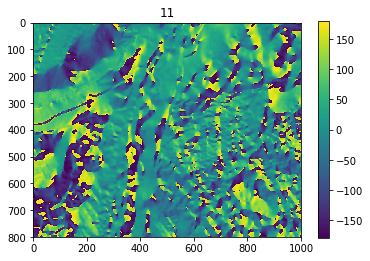

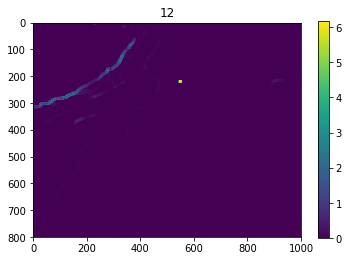

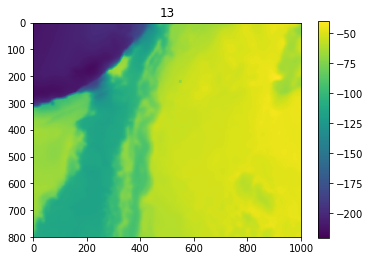

In [39]:
# scale features

#featf, feataxarr = plt.subplots(int(np.ceil(nplots/float(num_scales))),num_scales)

#featf, feataxarr = plt.subplots(nplots,1)

for i in range(nplots):
    #feataxarr[i].imshow(featstack[:,:,i])
    #feataxarr[i].colorbar()
    #featstack[:,:,i] = sklearn.preprocessing.scale(featstack[:,:,i])
    plt.figure(50+i)
    plt.imshow(featstack[:,:,i])
    plt.colorbar()
    plt.title(i)

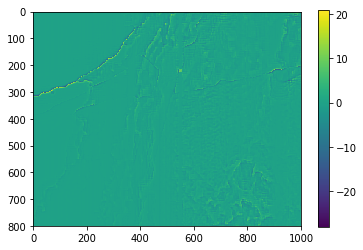

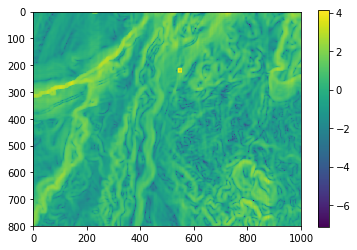

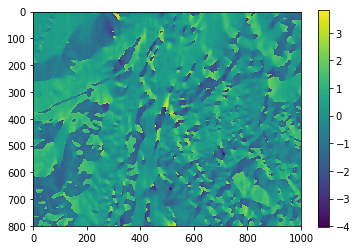

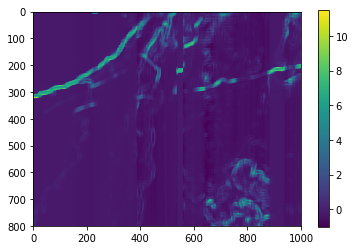

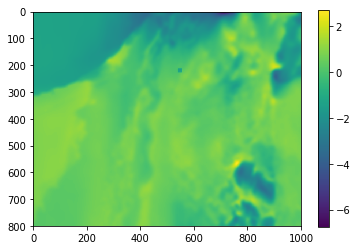

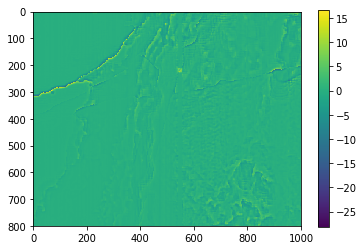

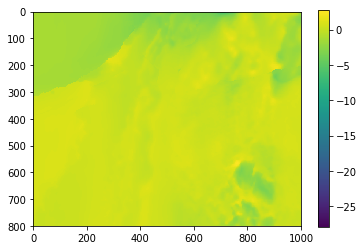

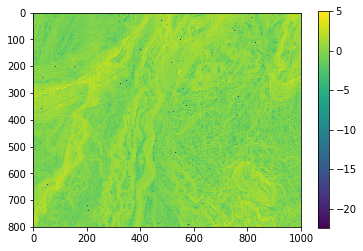

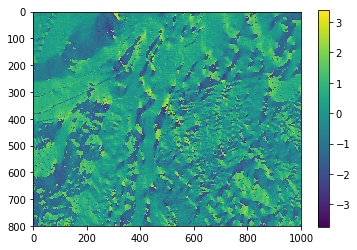

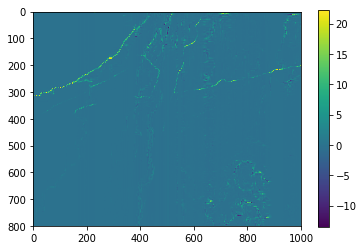

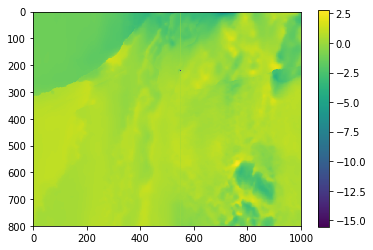

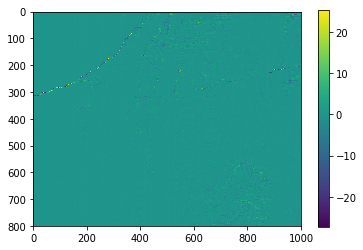

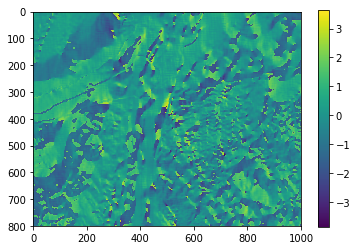

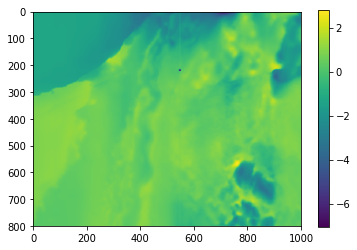

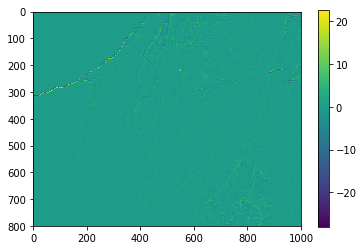

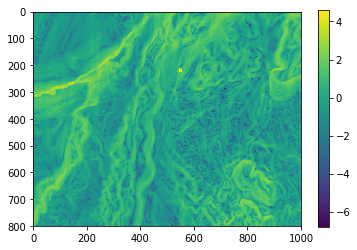

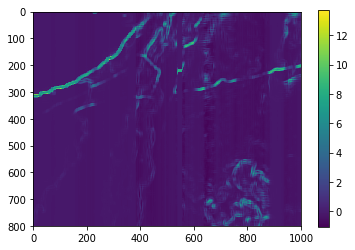

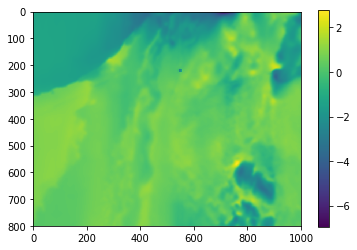

In [40]:
# scale features
featstack_orig = featstack
for i in range(featstack.shape[2]):
    featstack[:,:,i] = sklearn.preprocessing.scale(featstack[:,:,i])
    plt.figure(50+i)
    plt.imshow(featstack[:,:,i])
    plt.colorbar()

('shape pc.cov', (21, 21))
('reduced dimensions to', 16)
('shape img_pc', (800, 1000, 16))


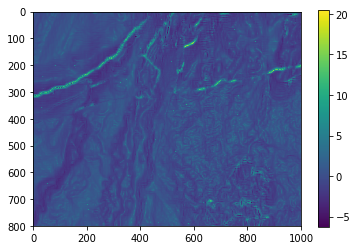

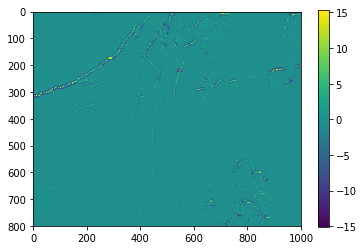

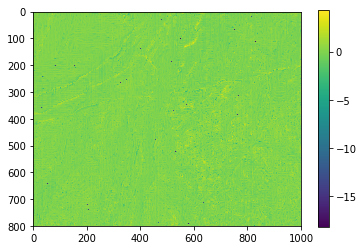

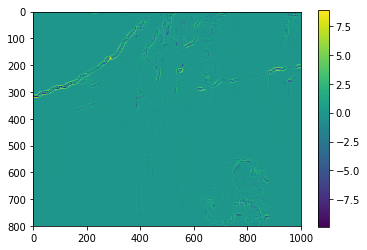

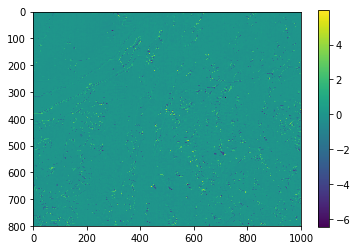

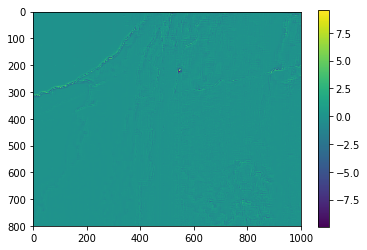

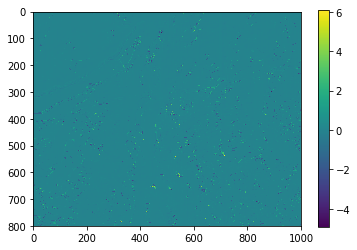

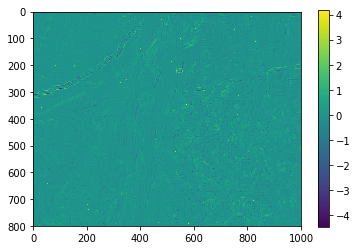

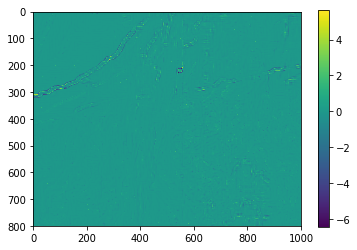

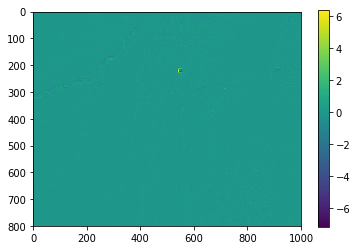

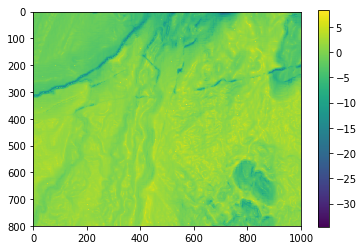

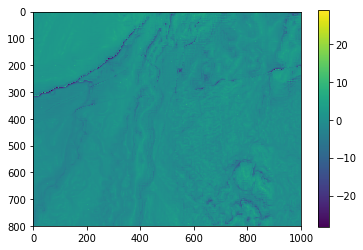

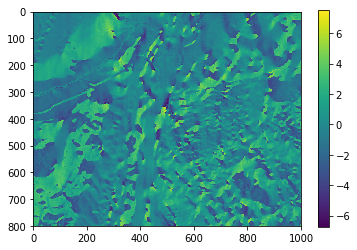

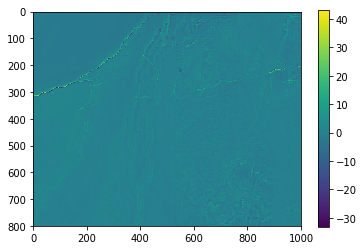

In [41]:
# normalise each feature dimension

import spectral 
pc = spectral.principal_components(featstack)
print("shape pc.cov",pc.cov.shape)

pc_0999 = pc.reduce(fraction=0.999)
print("reduced dimensions to", len(pc_0999.eigenvalues))
img_pc = pc_0999.transform(featstack)
print("shape img_pc",img_pc.shape)
for i in range(len(pc_0999.eigenvalues)):
    plt.figure(60+i)
    plt.imshow(img_pc[:,:,i])
    plt.colorbar()

('proc_data shape', (800, 1000, 16))
Initializing clusters along diagonal of N-dimensional bounding box.
Iteration 1...  0.0%Iteration 1...800000 pixels reassigned.
Iteration 2...  0.0%Iteration 2...205324 pixels reassigned.
Iteration 3...  0.0%Iteration 3...98156 pixels reassigned.
Iteration 4...  0.0%Iteration 4...90933 pixels reassigned.
Iteration 5...  0.0%Iteration 5...59211 pixels reassigned.
Iteration 6...  0.0%Iteration 6...19141 pixels reassigned.
Iteration 7...  0.0%Iteration 7...12611 pixels reassigned.
Iteration 8...  0.0%Iteration 8...12745 pixels reassigned.
Iteration 9...  0.0%Iteration 9...14712 pixels reassigned.
Iteration 10...  0.0%Iteration 10...17337 pixels reassigned.
Iteration 11...  0.0%Iteration 11...21223 pixels reassigned.
Iteration 12...  0

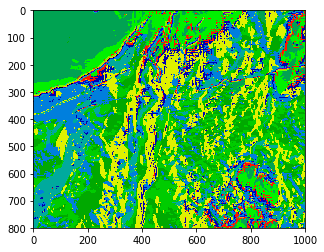

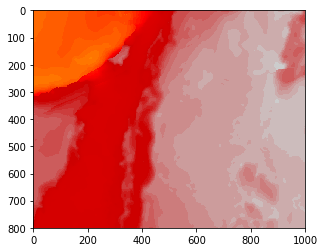

In [42]:

#import spectral

# test on just depth data
#proc_data=in_data[:,:,np.newaxis]

proc_data = img_pc

np.save('/Users/opizarro/data/FK20180119/bfeatures.npy',proc_data)

print( "proc_data shape", proc_data.shape )
num_clusters_max = 40
cluster_iterations = 150
classes, centres = spectral.kmeans(proc_data, num_clusters_max, cluster_iterations)
print("classes shape ", classes.shape)
plt.figure(10)
plt.imshow(classes, cmap = "nipy_spectral")
plt.figure(11)
plt.imshow(in_data, cmap = "nipy_spectral" )
plt.show(block=False)

In [43]:
print(len(centres))
num_clusters = len(centres)
print(len(classes))
print(np.amax(classes))
num_clusters = np.amax(classes)
print(np.unique(classes))

40
800
30
[11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 30]


In [44]:
# downsample to make problem more tractable


def mode_win(data,axis):
    return scipy.stats.mstats.mode(data,axis)[0]

from skimage.measure import block_reduce
tic = time.time()
#mode_data = scipy.ndimage.filters.generic_filter(classes, mode_win, size = 11)
mode_data = block_reduce(classes, block_size=(10,10), func = mode_win )
toc = time.time()
print("mode block time ",toc-tic)
print("mode_data shape", mode_data.shape)

('mode block time ', 20.484615087509155)
('mode_data shape', (80, 100, 10, 1))


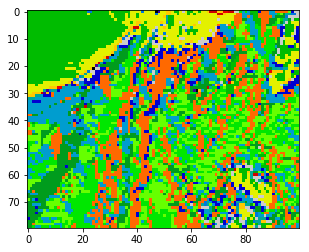

In [45]:

plt.figure(13)
plt.imshow(mode_data[:,:,0,0], cmap = "nipy_spectral")
plt.show(block=False)

('number of regions ', 1225)


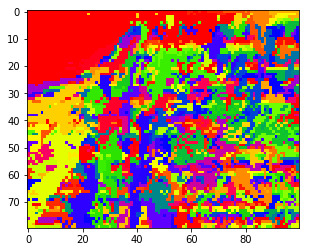

In [46]:
# region labeling with scikit
label_image, rnum = skimage.measure.label(mode_data[:,:,0,0],connectivity=2,return_num=True)
print("number of regions ", rnum)
plt.figure(113)
plt.imshow(label_image, cmap = "prism")
plt.show(block=False)

In [47]:
 
tic = time.time()
properties = skimage.measure.regionprops(label_image,mode_data[:,:,0,0])
toc = time.time()
print("properties calc time {} for {} regions ".format(toc-tic,rnum))
print("size of properties {}".format(len(properties)))
print(properties[500].centroid)

properties calc time 0.036190032959 for 1225 regions 
size of properties 1225
(33.0, 68.0)


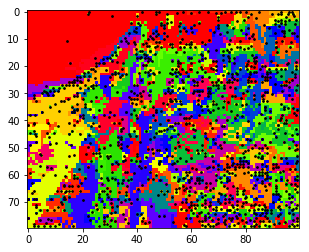

In [48]:
# plot centroids and create a list with cluster_ids for each region

plt.figure(114)
plt.imshow(label_image, cmap = "prism")
label_list = []
clusterid_list = []
centroid_list = []
for ri in range(len(properties)):
    plt.scatter(x=properties[ri].centroid[1],y=properties[ri].centroid[0],c='k',s=3)
    label_list.append(properties[ri].label)
    clusterid_list.append(int(properties[ri].mean_intensity))
    centroid_list.append(properties[ri].centroid)
plt.show(block=False)
    

In [49]:
# generate distance matrix
Dmat = np.zeros((len(properties),len(properties)))
for i in range(len(properties)):
    if i%100 == 0:
        print("\r iteration {}".format(i)),
    ivec = np.array(centroid_list[i])
    for j in range(i,len(properties)):
        #Dmat[i,j]=np.linalg.norm(ivec-np.array(properties[j].centroid))
        Dmat[i,j]=np.linalg.norm(ivec-np.array(centroid_list[j]))
        Dmat[j,i] = Dmat[i,j]

 iteration 1200


In [50]:
from ortools.constraint_solver import pywrapcp
# You need to import routing_enums_pb2 after pywrapcp!
from ortools.constraint_solver import routing_enums_pb2

print(np.array(properties[0].centroid)-np.array(properties[1].centroid))
print(np.linalg.norm(np.array(properties[0].centroid)-np.array(properties[1].centroid)))

def Distance_slow(i, j):
    global properties
    return np.linalg.norm((np.array(properties[i].centroid)-np.array(properties[j].centroid)))

def Distance(i,j):
    global Dmat
    global depot
    if i == depot or j == depot:
        d = 0
    else:
        d = Dmat[i,j]
    return d

[ 10.65055249  -8.11325967]
13.3887733086


In [51]:
# assemble generalised TSP

tsp_size = rnum+1 # num of locations plus one for dummy depot node
print("tsp_size", tsp_size)
num_vehicles = 1
depot = tsp_size-1 # last node is a dummy node
routing = pywrapcp.RoutingModel(tsp_size, num_vehicles, depot)

search_parameters = pywrapcp.RoutingModel.DefaultSearchParameters()
    # Setting first solution heuristic (cheapest addition).
search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Setting the cost function.
    # Put a callback to the distance accessor here. The callback takes two
    # arguments (the from and to node inidices) and returns the distance between
    # these nodes
routing.SetArcCostEvaluatorOfAllVehicles(Distance)

('tsp_size', 1226)


In [52]:
# disjunctions based on cluster ID 
# np.where expects an np array
cluster_modes = np.array(clusterid_list)
print("max cluster_modes ", max(cluster_modes))
print("length cluster_modes ",len(cluster_modes))
#print(np.where(cluster_modes==5))
#nodes = np.where(cluster_modes ==5)
#print(nodes)

#print(list(nodes[0]))
#print(nodes[0])
print(cluster_modes)
for i in range(num_clusters):
    #np.where returns a tuple with an np array as the first element and AddDisjunction expects a list
    nodes = list(np.where(cluster_modes == i)[0])
    # remove depot node (typicall 0) (as default depo)
    if depot in nodes:
        nodes.remove(depot)
        print("removed depot node ",depot)
    print(np.where(cluster_modes == i))
    if (len(nodes) > 0):
        routing.AddDisjunction(nodes)
        print("cluster ", i)
        print("length ",len(nodes))
        print("max id", max(nodes))
    else:
        print("no nodes for clusterid ",i)
    
  

('max cluster_modes ', 27)
('length cluster_modes ', 1225)
[19 15 22 ..., 27 22 16]
(array([], dtype=int64),)
('no nodes for clusterid ', 0)
(array([], dtype=int64),)
('no nodes for clusterid ', 1)
(array([], dtype=int64),)
('no nodes for clusterid ', 2)
(array([], dtype=int64),)
('no nodes for clusterid ', 3)
(array([], dtype=int64),)
('no nodes for clusterid ', 4)
(array([], dtype=int64),)
('no nodes for clusterid ', 5)
(array([], dtype=int64),)
('no nodes for clusterid ', 6)
(array([], dtype=int64),)
('no nodes for clusterid ', 7)
(array([], dtype=int64),)
('no nodes for clusterid ', 8)
(array([], dtype=int64),)
('no nodes for clusterid ', 9)
(array([], dtype=int64),)
('no nodes for clusterid ', 10)
(array([  5, 188, 257, 431]),)
('cluster ', 11)
('length ', 4)
('max id', 431)
(array([], dtype=int64),)
('no nodes for clusterid ', 12)
(array([  6, 144, 246, 287, 359, 375, 377, 420, 430]),)
('cluster ', 13)
('length ', 9)
('max id', 430)
(array([  22,   27,   84,   87,   88,  100,  10

In [53]:

# Solve, returns a solution if any.
tic = time.time()
assignment = routing.SolveWithParameters(search_parameters)
toc = time.time()

print("solving tsp time ", toc-tic)    


('solving tsp time ', 1.9697139263153076)


In [54]:
      


    
#assignment = routing.Solve()

In [55]:
# modified to not show dummy depot node
#
solnodes = []
print("solving tsp time ", toc-tic)
if assignment:
    print "Total distance of all routes: " + str(assignment.ObjectiveValue()) + "\n"
    for vehicle_nbr in range(num_vehicles):
        index = routing.Start(vehicle_nbr)
        index_next = assignment.Value(routing.NextVar(index))
        route = ''
        route_dist = 0
        route_demand = 0

        while not routing.IsEnd(index_next):
            node_index = routing.IndexToNode(index)
            node_index_next = routing.IndexToNode(index_next)
            if node_index != depot:
                route += str(node_index) + " -> "
            # Add the distance to the next node.
            route_dist += Distance(node_index, node_index_next)
            # Add demand.
            #route_demand += demands[node_index_next]
            index = index_next
            index_next = assignment.Value(routing.NextVar(index))
            solnodes.append(node_index)
            
        node_index = routing.IndexToNode(index)
        node_index_next = routing.IndexToNode(index_next)
        if node_index_next != depot:
            route += str(node_index) + " -> " + str(node_index_next)
        else:
            route += str(node_index)
        solnodes.append(node_index)
        route_dist += Distance(node_index, node_index_next)
        print "Route for vehicle " + str(vehicle_nbr) + ":\n\n" + route + "\n"
        print "Distance of route " + str(vehicle_nbr) + ": " + str(route_dist)
        #print "Demand met by vehicle " + str(vehicle_nbr) + ": " + str(route_demand) + "\n"
else:
    print 'No solution found.'


    

('solving tsp time ', 1.9697139263153076)
Total distance of all routes: 104

Route for vehicle 0:

1120 -> 1136 -> 1153 -> 1206 -> 1207 -> 1224 -> 1189 -> 1205 -> 1223 -> 1188 -> 915 -> 871 -> 870 -> 375 -> 299 -> 431

Distance of route 0: 113.350270062


[97.428571428571431, 96.0, 97.333333333333329, 97.0, 97.666666666666671, 96.0, 88.5, 87.166666666666671, 88.5, 86.5, 86.0, 85.0, 83.5, 96.0, 89.0, 62.0]


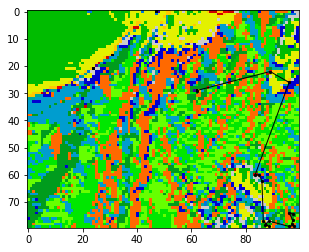

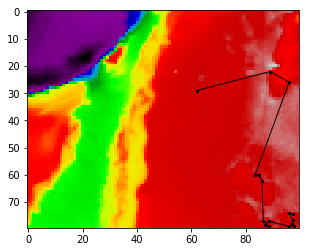

In [56]:
xsol = []
ysol = []



plt.figure(13)
plt.imshow(mode_data[:,:,0,0], cmap = "nipy_spectral")
#plt.show(block=False)
for i in solnodes[1:]:
   # print(i)
    xsol.append(properties[i].centroid[1])
    ysol.append(properties[i].centroid[0])
print(xsol)
#plt.figure(13)
plt.plot(xsol,ysol,'k',lw=1)
plt.scatter(xsol,ysol,c='k',s=5)
plt.show(block=False)
   
#plot over bathymetry

plt.figure(14)
plt.imshow(skimage.transform.downscale_local_mean(in_data,(10,10)), cmap = "nipy_spectral")
plt.plot(xsol,ysol,'k',lw=1)
plt.scatter(xsol,ysol,c='k',s=5)
plt.show(block=False)
    

In [57]:
if assignment:
    # Solution cost.
    print(assignment.ObjectiveValue())
    # Inspect solution.
    # Only one route here; otherwise iterate from 0 to routing.vehicles() - 1
    route_number = 0
    node = routing.Start(route_number)
    route = ''
    while not routing.IsEnd(node):
        route += str(node) + " -> "
        node = assignment.Value(routing.NextVar(node))
    ##route += '0'
    print(route)
else:
    print('No solution found.')

104
1225 -> 1120 -> 1136 -> 1153 -> 1206 -> 1207 -> 1224 -> 1189 -> 1205 -> 1223 -> 1188 -> 915 -> 871 -> 870 -> 375 -> 299 -> 431 -> 


In [58]:
%matplotlib --list

Available matplotlib backends: ['osx', 'qt4', 'qt5', 'gtk3', 'notebook', 'wx', 'qt', 'nbagg', 'gtk', 'tk', 'inline']
